# Actief
This is the first label of our dataset we'll try to predict.
## Details
> Een actieve of passieve constructie wijst op de vorm die  het  werkwoord  aanneemt  in  de  zin.  Er  zouden eerder   actieve   constructies   worden   gebruikt   in koppen, dan passieve.Ook   verstaan   we   in   deze   studie   onder   actieve constructies koppen die directer overkomen dan hun concurrentie, die misschien wat meer omslachtig is.Bij  een  directe  kop  staat  het  hoofdnieuws  van  het artikel vooraan, een indirectere kop geeft eerst nog watalgemene of onbeduidende informatie.
## Example
> Actief: Weg met perfectie: H&M werktde kleine details van bikinimodellen niet langer weg
> Passief:  Weg  met  perfectie:  striemen,  beharing en littekens     van badpakmodellen H&M (worden) niet langer gefotoshopt
> Directer: Proximus werktaan  eigen  Belgische Netflix
> Indirecter: Proximus denktaan  eigen  Belgische Netflix
## Data

In [25]:
from util import get_cls_train_test

train_x, train_y, test_x, test_y = get_cls_train_test("Actief")
train_y.value_counts()

1    569
0    112
Name: Actief, dtype: int64

## Approach 1: Past paricle using own function
A passive construction will often contain a past particle, so it might be useful to train a model to search for those. However, this won't be an ideal scenario, since more indirect forms (like the one given above using "to think") will be ignored with this.
In the English language, we have following markers for a passive construction: be, -ed and by ([src](https://www.academypublication.com/issues/past/jltr/vol01/06/32.pdf), Classification and SLA Studies of Passive Voice, Yuanying Wang). This translates in dutch to forms of "worden", "ge-" and "door".

In [26]:
# Warning: This manually writtn functions are prone to overfitting, so it's better to actually use nlp methods
def is_passive(headline):
    # TODO: Maybe I can check this with spacy? Since this manual construction is probbly overfitting

    # Check if any word in headline start with "ge"
    for word in headline.split():
        if word.startswith("ge") or word.startswith("Ge"):
            return True
        if word == "door" or word == "Door":
            return True
        if "word" in word or word in ["zijn", "is", "ben", "bent"]:  # Check for any form of the verb "worden"
            return True
    return False


def is_active(headline):
    return not is_passive(headline)


print(is_passive("Verdachte gevlucht na overval"))

True


f-score: 0.584192439862543
Confusion matrix: (TP: 22, FP: 19, FN: 102, TN: 85)
Accuracy=46.93% (107/228)


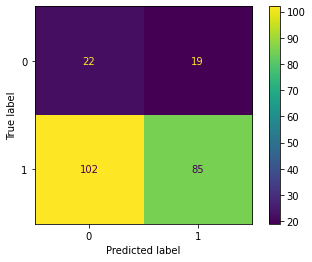

In [27]:
from util import print_evalution
import numpy as np

predictions = np.vectorize(is_passive)(test_x)
print_evalution(test_y, predictions)

Too much words starting with “Ge-” (e.g. Geen,gewoon, gebouw, …) are seen as passive indications, even though they aren’t. Let’s try without the “ge-” prefix detection.

f-score: 0.7714285714285715
Confusion matrix: (TP: 13, FP: 28, FN: 52, TN: 135)
Accuracy=64.91% (148/228)


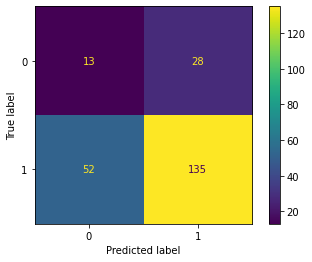

In [28]:
def is_active_no_ge_prefix(headline):
    # Check if any word in headline start with "ge"
    for word in headline.split():
        if word == "door" or word == "Door":
            return False
        if "word" in word or word in ["zijn", "is", "ben", "bent"]:  # Check for any form of the verb "worden"
            return False
    return True


from util import print_evalution
import numpy as np

predictions = np.vectorize(is_active_no_ge_prefix)(test_x)
print_evalution(test_y, predictions)

## Approach 2: Past particle using spacy

In [29]:
import spacy
from pprint import pprint

nlp = spacy.load('nl_core_news_sm')
pprint(list([(x.text, x.pos_, x.tag_) for x in nlp("Verdachte gevlucht na overval")]))

[('Verdachte', 'PROPN', 'N|eigen|mv|basis'),
 ('gevlucht', 'VERB', 'WW|vd|vrij|zonder'),
 ('na', 'ADP', 'VZ|init'),
 ('overval', 'NOUN', 'N|soort|ev|basis|zijd|stan')]


In [30]:
def contains_past_partiple(headline):
    return any('|vd|' in x.tag_ for x in nlp(headline))


def is_active_pp_spacy(headline):
    return not contains_past_partiple(headline)


print(is_active_pp_spacy(u"Slachtoffer is vermoord in Antwerpen"))
print(is_active_pp_spacy(u"Verdachte pleegt moord in Antwerpen"))

False
True


f-score: 0.7942028985507246
Confusion matrix: (TP: 20, FP: 21, FN: 50, TN: 137)
Accuracy=68.86% (157/228)


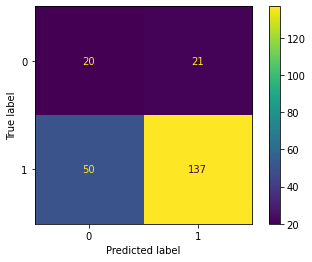

In [31]:
predictions = np.vectorize(is_active_pp_spacy)(test_x)
print_evalution(test_y, predictions)

## Approach 3: Tf-idf
Passive sentences often contain chargrams like "ge-", "-d", "-t", "door" or forms of "zijn". Because of this, word or character tokenized tf-idf might work well.


### Word-tokenized

f-score: 0.9029126213592233
Confusion matrix: (TP: 2, FP: 39, FN: 1, TN: 186)
Accuracy=82.46% (188/228)


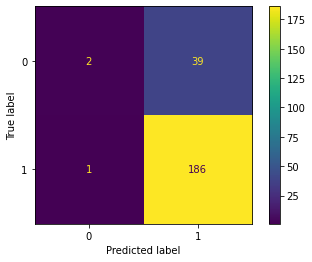

In [42]:
from imblearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm

model = Pipeline([
    ('vectorizer', TfidfVectorizer(ngram_range=(1, 1))),
    ('classifier', svm.LinearSVC(random_state=42))
])

model.fit(train_x, train_y)

prediction = model.predict(test_x)
print_evalution(test_y, prediction)

In [38]:
from util import show_most_informative_features
show_most_informative_features(model)

0.9423          geeft    -1.4026           twee
0.8565     vlaanderen    -1.3728          omdat
0.7812     temptation    -1.3492       opgepakt
0.6972   gewaarschuwd    -1.2324             dj
0.6917           auto    -1.2024       verdacht
0.6903        politie    -1.1650   geschiedenis
0.6783            dag    -1.1412      herbeleef
0.6690          tegen    -1.1127            tot
0.6684        bekende    -1.1102         vriend
0.6613             va    -1.0826           belg


Those are not what I expected (I expected more past particles on th negative side, "verdacht" and "opgepakt" are the only ones in the top 10). "Door" is also a logical one on the negative side (but dissapeared because the random seed wasn't fixed).

### Character-tokenized

f-score: 0.8980582524271844
Confusion matrix: (TP: 1, FP: 40, FN: 2, TN: 185)
Accuracy=81.58% (186/228)


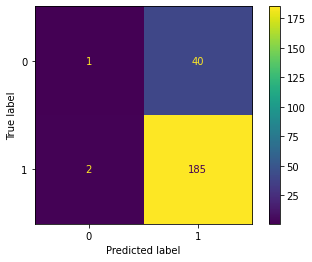

In [43]:
model = Pipeline([
    ('vectorizer', TfidfVectorizer(analyzer="char_wb", ngram_range=(1, 4))), # "-d" to "door"
    ('classifier', svm.LinearSVC(random_state=42))
])

model.fit(train_x, train_y)

prediction = model.predict(test_x)
print_evalution(test_y, prediction)

Let's take a look at which characters are important:

In [40]:
show_most_informative_features(model)

0.7428              "    -0.9306             ak
0.6615            laa    -0.8761            doo
0.6575             ol    -0.8609             u 
0.6429              l    -0.8525            erd
0.6384            lt     -0.8006            era
0.6300            ag     -0.7675            gel
0.6118             ov    -0.7650            ng 
0.6103             bl    -0.7536            ot 
0.5940             li    -0.7345             af
0.5808              o    -0.6986            af 


"doo(r)" was expectd. " ge-" is surprisingly not part of the top 10 negatives (but "gel-" is). "-erd" is also one that makes sense.

## Approach 4: char-gram Tf-idf + past particle as extra feature

f-score: 0.8980582524271844
Confusion matrix: (TP: 1, FP: 40, FN: 2, TN: 185)
Accuracy=81.58% (186/228)


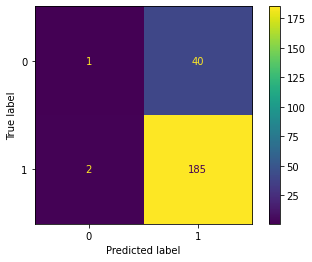

In [44]:
from sklearn.pipeline import FeatureUnion
from util import FunctionTransformer

model = Pipeline([
    ('union', FeatureUnion([
        ('vectorizer', TfidfVectorizer(analyzer="char_wb", ngram_range=(1, 4))),
        ('consecutive_pronouns', FunctionTransformer(func=is_active_pp_spacy))
    ])),
    ('classifier', svm.LinearSVC(random_state=0))
])

model.fit(train_x, train_y)

prediction = model.predict(test_x)
print_evalution(test_y, prediction)

Surprisingly, this doesn't give any increase.